# Exploração, Limpeza dos dados e Visualizações

Trabalharemos com três datasets. O primeiro é um subconjunto do [ICOADS](https://icoads.noaa.gov/) (International Comprehensive Ocean-Atmosphere Data Set) fornecido pela [NOAA](noaa.gov) (National Oceanic and Atmospheric Administration) que possui vários dados climáticos de cobertura mensal, desde 1800 até o presente, e com abrangência marítima; Possui dados como temperatura do mar, umidade, pressão, cobertura de nuvens, velocidade de vento, etc.

Na célula abaixo, há um código que baixa o subconjunto que usaremos diretamente da fonte oficial. Não colocamos estes arquivos no GitHub por conta do limite de tamanho imposto sobre os uploads/commits.

In [1]:
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/sst.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/rhum.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/slp.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/vwnd.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/wspd.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/cldc.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/air.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/uwnd.mean.nc
# !wget ftp://ftp.cdc.noaa.gov/Datasets/icoads/2degree/enh/sflx.mean.nc

O segundo grande conjunto de dados é o [HURDAT2](https://www.kaggle.com/noaa/hurricane-database) cuja fonte oficial é a [NHC](www.nhc.noaa.gov) (National Hurricane Center), divisão da NOAA responsável pelos furações e tempestades.

Os dados do Kaggle fornecem dados de tempestades e furacões desde o século XIX até 2015 no pacífico e atlântico, mas iremos focar nossa análise no dadaset do atlântico.

O terceiro, é um dado com o índice PDI, mas ele já vem da fonte em boas condições e não necessita de limpeza. Veja mais no notebook [PowerDissipationIndex.ipynb](https://github.com/reneroliveira/Hurricane_Project/blob/master/PowerDissipationIndex.ipynb).

In [192]:
## Imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from mpl_toolkits.basemap import Basemap,shiftgrid
import pandas as pd
import netCDF4 as nc
from math import sin, cos, sqrt, atan2, radians

import scipy
import geopy
import xarray
import networkx
import requests
import cartopy
import tropycal

import tropycal.tracks as tracks
import tropycal.tornado as tornado
import datetime as dt

import statsmodels.api as sm
from statsmodels.api import OLS

## Dataset ICOADS

Vamos analisar os dados baixados acima. O formato .nc é legível ao python através da biblioteca netCDF4 que está nos pré-requisitos. Além disso, serão necessárias instalar os pacotes abaixo; Descomente a célula, execute-a e dê um "Restart Runtime" no Jupyter. Certifique-se que instalou todos os pré-requisitos do arquivo "requirements.txt".

In [ ]:
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip

### Análise de dados faltantes

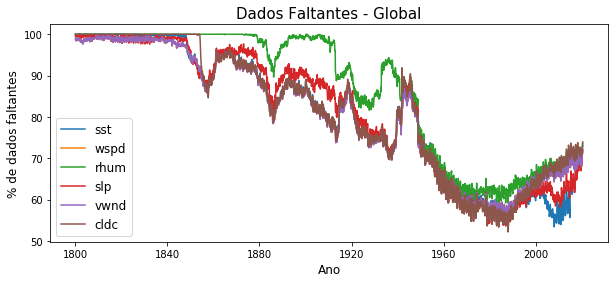

<class 'numpy.ma.core.MaskedArray'>


In [7]:
sst_mean = nc.Dataset('sst.mean.nc','r')
rhum_mean = nc.Dataset('rhum.mean.nc','r')
wspd_mean = nc.Dataset('wspd.mean.nc','r')
slp_mean = nc.Dataset('slp.mean.nc','r')
vwnd_mean = nc.Dataset('vwnd.mean.nc','r')
cldc_mean = nc.Dataset("cldc.mean.nc",'r')

lats = sst_mean.variables['lat'][:]
lons = sst_mean.variables['lon'][:]
time = sst_mean.variables['time'][:]

sst = sst_mean.variables['sst'][:,:,:]
rhum = rhum_mean.variables['rhum'][:,:,:]
wspd = wspd_mean.variables['wspd'][:,:,:]
slp = slp_mean.variables['slp'][:,:,:]
vwnd = vwnd_mean.variables['vwnd'][:,:,:]
cldc = cldc_mean.variables['cldc'][:,:,:]

sst_mean.close()
wspd_mean.close()
rhum_mean.close()
slp_mean.close()
vwnd_mean.close()
cldc_mean.close()

period = pd.date_range(start = "1800-01-01",end = "2020-07-01", freq = "MS").to_pydatetime().tolist()

def get_missing(data:list,labels:list)->dict:
    missing={}
    lenght = data[0].shape[0]
    for j,item in enumerate(data):
        missing[labels[j]] = []
        for i in range(lenght):
            missing[labels[j]].append(100*np.sum(item[i].mask)/item[i].data.size)
    return missing

missing = get_missing([sst,wspd,rhum,slp,vwnd,cldc],['sst','wspd','rhum','slp','vwnd','cldc'])

fig,ax = plt.subplots(1,1,figsize=(10,4))

ax.set_title("Dados Faltantes - Global",fontsize=15)
ax.set_xlabel("Ano",fontsize=12)
ax.set_ylabel("% de dados faltantes",fontsize=12)
for key,value in missing.items():
    ax.plot(period,missing[key],label=key)
ax.legend(loc='best',fontsize=12);
fig.savefig('../figs/missing-global.png')
plt.show()

print(type(sst))

__Legenda:__

- sst: Sea Surface Temperature (Temperatura na superfície do mar)
- wspd: Scalar Wind Speed (Velocidade de vento escalar)
- rhum: Relative Humidity (Umidade relativa)
- slp: Sea Level Pressure (Pressão no nível do mar)
- vwnd: V-wind component (Componente V-wind)
- cldc: Cloudiness (Nebulosidade das nuvens)


Como os continentes representam aproximadamente $29,1\%$ da suferfície terrestre e nossos dados só preenchem os oceanos, os continentes são preenchidos como dados inexistentes. Então naturalmente nossa cota inferior de dados faltantes é essa porcentagem.

Note que os dados lidos vem no formato de "numpy masked array" que tem um atributo "mask" que é indicadora de dado faltante, isso nos ajudará a lidar com esses dados.

Como vemos no plot acima temos várias décadas com níveis de dados faltantes acima de $90\%$ mas vamos analisar focadamente e atlântico norte, que é nossa região de estudos.

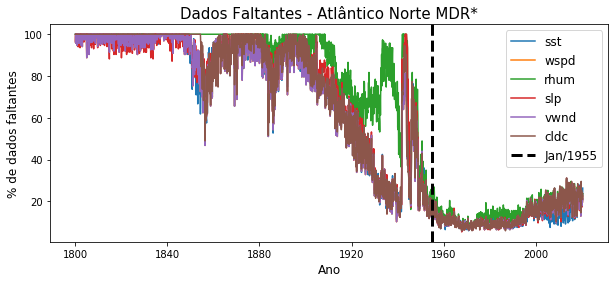

In [14]:
sst_at = sst[:,34:40,51:82] #10°-20°N, 80°-20°W
wspd_at = wspd[:,34:40,51:82]
rhum_at = rhum[:,34:40,51:82]
slp_at = slp[:,34:40,51:82]
vwnd_at = vwnd[:,34:40,51:82]
cldc_at = cldc[:,34:40,51:82]

# sst_pac = sst[:,14:45,0:41] #0°-60°N, 100°W-180°W
# wspd_pac = wspd[:,14:45,0:41]
# rhum_pac = rhum[:,14:45,0:41]

missing_at = get_missing([sst_at,wspd_at,rhum_at,slp_at,vwnd_at,cldc_at],['sst_at','wspd_at','rhum_at','slp_at','vwnd_at','cldc_at'])
# missing_pac = get_missing([sst_pac,wspd_pac,rhum_pac],['sst_pac','wspd_pac','rhum_pac'])

# fig,(ax,ax1) = plt.subplots(2,1,figsize=(10,8))
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title("Dados Faltantes - Atlântico Norte MDR*",fontsize=15)
ax.set_xlabel("Ano",fontsize=12)
ax.set_ylabel("% de dados faltantes",fontsize=12)
for key,value in missing_at.items():
    ax.plot(period,missing_at[key],label=key[0:-3])
plt.axvline(x=period[1860],label = "Jan/1955",color = 'black', lw=3,ls='--')

ax.legend(loc='best',fontsize=12);
fig.savefig('../figs/missing_mdr.png')

\*MDR é a abreviação de _Main Development Region_ ou região central de desenvolvimento dos furacões no Atlântico Norte e se refere à faixa 10°-20°N, 80°-20°W.

Vemos que a partir de 1950-1960, os dados começam a ficar mais completos na região de estudos. Então, para entender a relação as variáveis, iremos trabalhar a partir desta data.

Entretanto, nada nos impede de usar os dados mais antigos, já que as medições não variam muito quando estão perto, se quisermos trabalhar com tendências de longo prazo podemos cortar os dados a partir de 1920, trabalhar com a média das regiões estudadas, mesmo que com $~70\%$ de dados faltantes. Isso pois temos a array indicadora, que pode ajudar em modelos, e também essa porcentagem é um pouco mais baixa devido às faixas continentais considaradas no corte de coordenadas.

Abaixo temos um exemplo de como os dados de temperatura estão distribuídos em Janeiro de 1955 

### Visualização

In [15]:
#Transforms longitude ranges from [0,360] para [-180,180] --> useful for plot

sst[:],lonsn = shiftgrid(180,sst[:],lons,start=False)
wspd[:],lonsn = shiftgrid(180,wspd[:],lons,start=False)
# shum[:],lonsn = shiftgrid(180,shum[:],lons,start=False)
rhum[:],lonsn = shiftgrid(180,rhum[:],lons,start=False)
lons = lonsn

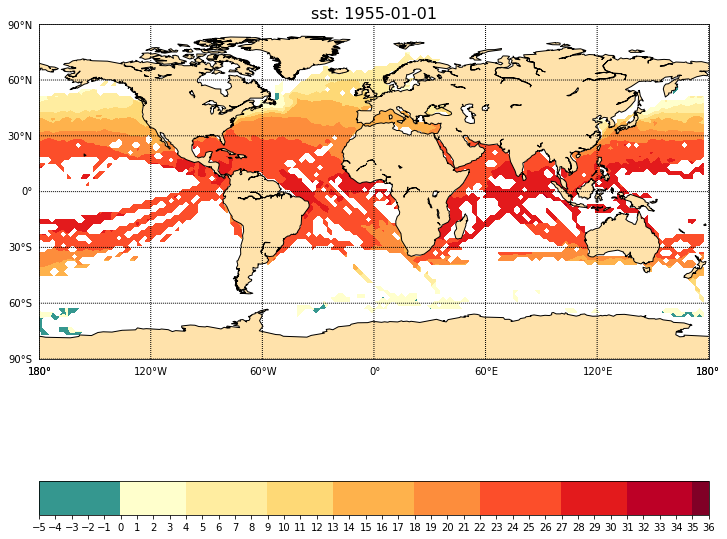

In [18]:
#Reference: https://annefou.github.io/metos_python/04-plotting/
time_index = 1860

fig = plt.figure(figsize=[12,15])
ax = fig.add_subplot(1, 1, 1)
ax.set_title("sst: {}".format(period[time_index].date()),fontsize=16)
map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c', ax=ax)
map.drawcoastlines()
map.fillcontinents(color='#ffe2ab')

map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])


llons, llats = np.meshgrid(lons, lats)
x,y = map(llons,llats)


cmap = c.ListedColormap(['#35978f','#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c',
                        '#fc4e2a','#e31a1c','#bd0026','#800026'])
bounds=list(np.arange(-5,37,1))
# bounds=list(np.arange(10,100,5))
norm = c.BoundaryNorm(bounds, ncolors=cmap.N)

cs = map.contourf(x,y,sst[time_index], cmap=cmap, norm=norm, levels=bounds)
fig.colorbar(cs, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, ax=ax, orientation='horizontal');

plt.savefig('../figs/sst_1955.png')

### Agregação dos Dados MDR

Criaremos a seguir uma dataframe com as médias espaciais da região MDR, para análise futura com o PDI. Usamos essa média baseados na premissa razoável de que nesse corte espacial da MDR do atlântico os valores não variam muito dentro de um mês. Fazemos essa médias para análises de mais longo prazo como podem ver no notebook do [PDI](https://github.com/reneroliveira/Hurricane_Project/blob/master/PowerDissipationIndex.ipynb).

In [21]:
print(period[1860]) # -- Jan/1955
def get_mean(data):
    size = data.shape[0]
    new = np.array([])
    for i in range(size):
        new = np.append(new,np.mean(data[i,:,:]))
    return new

#Começaremos do índice 1788, representando Janeiro de 1949, para corresponder com os dados de PDI.
data_at = pd.DataFrame(get_mean(sst_at[1788:,:,:]),columns =["sst"])
period_df = pd.DataFrame(period[1788:],columns = ["Date"])
period_df['Year']=period_df.Date.map(lambda x: x.year)
period_df['Month']=period_df.Date.map(lambda x: x.month)
data_at['rhum'] = pd.DataFrame(get_mean(rhum_at[1788:,:,:]),columns =["rhum"])
data_at['slp'] = pd.DataFrame(get_mean(slp_at[1788:,:,:]),columns =["slp"])
data_at['wspd'] = pd.DataFrame(get_mean(wspd_at[1788:,:,:]),columns =["wspd"])
data_at['vwnd'] = pd.DataFrame(get_mean(vwnd_at[1788:,:,:]),columns =["vwnd"])
data_at['cldc'] = pd.DataFrame(get_mean(cldc_at[1788:,:,:]),columns =["cldc"])

atlantic_mdr = pd.concat([period_df,data_at],axis=1)


#Código que calcula desvios da temperatura do mar em relação à média histórica
#Apenas para visualização
cum_sum = {}
for i in range(1,13):
    cum_sum[i]=0
k=0 #year count
for i in range(0,atlantic_mdr.shape[0]-12):
    month = atlantic_mdr.iloc[i,:].Month
    if month%12==1:
        k+=1
    cum_sum[month]+=atlantic_mdr.iloc[i,3]
    atlantic_mdr.loc[atlantic_mdr.index[i],'sst_anomaly'] = atlantic_mdr.iloc[i,3]-cum_sum[month]/k
atlantic_mdr.drop('sst_anomaly',axis=1).to_csv('atlantic_mdr.csv',index=False)
atlantic_mdr.iloc[12:24,:]

1955-01-01 00:00:00


,Date,Year,Month,sst,rhum,slp,wspd,vwnd,cldc,sst_anomaly
12,1950-01-01,1950,1,24.782794,75.675756,1012.699219,7.800527,-2.709708,4.139401,-0.138282
13,1950-02-01,1950,2,24.251776,78.633936,1012.883875,6.583213,-2.401613,3.965875,-0.129778
14,1950-03-01,1950,3,24.395219,78.334148,1013.134516,6.621354,-2.062759,4.087092,-0.020090
15,1950-04-01,1950,4,24.900423,77.248673,1011.096354,5.958877,-0.454326,3.146995,-0.010952
16,1950-05-01,1950,5,25.355377,79.638362,1010.577563,6.486837,0.516981,4.291411,-0.061999
17,1950-06-01,1950,6,26.110960,81.022388,1009.393293,6.946026,2.076482,4.650387,0.087756
18,1950-07-01,1950,7,26.516357,80.354432,1007.978285,6.342278,2.375750,5.184904,-0.070533
19,1950-08-01,1950,8,27.312561,81.914887,1007.856950,5.279884,1.956808,5.109233,-0.081636
20,1950-09-01,1950,9,27.811223,80.212305,1007.869104,4.947030,0.525868,5.305648,-0.057075
21,1950-10-01,1950,10,27.702060,80.523185,1010.697798,4.656318,-1.037250,4.423469,-0.026328


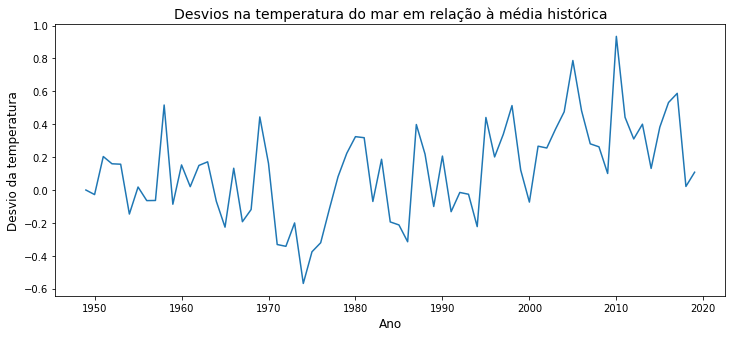

In [26]:
fig,ax = plt.subplots(1,1,figsize=(12,5))

ax.plot(np.arange(1949,2021,1),atlantic_mdr.groupby(['Year']).agg({'sst_anomaly':np.mean})['sst_anomaly'])
ax.set_title("Desvios na temperatura do mar em relação à média histórica",fontsize=14)
ax.set_xlabel("Ano",fontsize=12)
ax.set_ylabel("Desvio da temperatura",fontsize=12);


Podemos ver que após 1970-1980 inicia-se uma tendência crescente de aumento de temperatura do mar em relação à média histórica.

In [28]:
corr = atlantic_mdr.corr()
corr.style.background_gradient(cmap='coolwarm')

,Year,Month,sst,rhum,slp,wspd,vwnd,cldc,sst_anomaly
Year,1.000000,-0.010203,0.145686,-0.098235,0.048908,0.646453,-0.035567,0.241832,0.379038
Month,-0.010203,1.000000,0.762722,0.392842,-0.434216,-0.385048,0.151316,0.380311,-0.017207
sst,0.145686,0.762722,1.000000,0.635370,-0.632031,-0.416486,0.432498,0.559898,0.312656
rhum,-0.098235,0.392842,0.635370,1.000000,-0.768182,-0.380635,0.803748,0.305508,0.014696
slp,0.048908,-0.434216,-0.632031,-0.768182,1.000000,0.317397,-0.812037,-0.548567,0.129542
wspd,0.646453,-0.385048,-0.416486,-0.380635,0.317397,1.000000,-0.253309,0.007404,0.040588
vwnd,-0.035567,0.151316,0.432498,0.803748,-0.812037,-0.253309,1.000000,0.236100,-0.002599
cldc,0.241832,0.380311,0.559898,0.305508,-0.548567,0.007404,0.236100,1.000000,0.019122
sst_anomaly,0.379038,-0.017207,0.312656,0.014696,0.129542,0.040588,-0.002599,0.019122,1.000000


Alguma correlações fortes interessantes:
    
- Temperatura do mar (sst) com ano (Year)
- Temperatura do mar (sst) e umidade (rhum)
- Velocidade de vento (wspd) e ano (Year)
- Pressão (slp) e Umidade (rhum)

Análises mais aprofundadas dessas variáveis veremos no notebook de análise do PDI. 

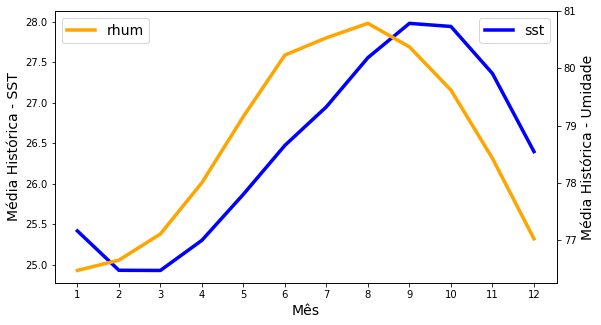

In [105]:
month_sst = atlantic_mdr.groupby('Month')['sst'].mean()
month_rhum = atlantic_mdr.groupby('Month')['rhum'].mean()
# month_slp = atlantic_mdr.groupby('Month')['slp'].mean()
# month_cldc = atlantic_mdr.groupby('Month')['cldc'].mean()

m = np.arange(1,13)
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.plot(month_sst,lw=3.5,color='blue',label = 'sst')
ax.set_xticks(m);
ax.set_xlabel("Mês",fontsize=14)
ax.set_ylabel("Média Histórica - SST",fontsize=14)

ax2 = ax.twinx()
ax2.plot(month_rhum,lw=3.5,color='orange',label = 'rhum')
ax2.set_ylabel("Média Histórica - Umidade",fontsize=14)
ax.legend(loc='best',fontsize=14);
ax2.legend(loc='upper left',fontsize=14);
plt.savefig("../figs/mensal_sst_rhum.jpg")

Veja acima que os picos de temperatura e umidade, coincidem razoavelmente com a temporada de furacões.

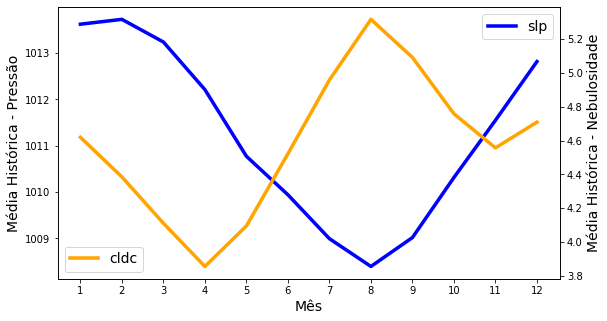

In [110]:
month_slp = atlantic_mdr.groupby('Month')['slp'].mean()
month_cldc = atlantic_mdr.groupby('Month')['cldc'].mean()

m = np.arange(1,13)
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.plot(month_slp,lw=3.5,color='blue',label = 'slp')
ax.set_xticks(m);
ax.set_xlabel("Mês",fontsize=14)
ax.set_ylabel("Média Histórica - Pressão",fontsize=14)

ax2 = ax.twinx()
ax2.plot(month_cldc,lw=3.5,color='orange',label = 'cldc')
ax2.set_ylabel("Média Histórica - Nebulosidade",fontsize=14)
ax.legend(loc='best',fontsize=14);
ax2.legend(loc='lower left',fontsize=14);
plt.savefig("../figs/mensal_slp_cldc.jpg")

O pico de nebulosidade das nuvens também coincide de forma razoável com a temporada de furacões. Assim como os valores mais baixos de pressão. Essas características estão relacionadas com a formação do evento de tempestade forte ou furacão.

## Dataset HURDAT2 (Hurricane) - Análise e Limpeza

Passemos agora a analisar os dados de tempestades e furacões.

In [125]:
# O foco principal do trabalho se dará nos dados do atlântico
data_atl = pd.read_csv('atlantic.csv',parse_dates=['Date'])
data_atl.dtypes

ID                          object
Name                        object
Date                datetime64[ns]
Time                         int64
Event                       object
Status                      object
Latitude                    object
Longitude                   object
Maximum Wind                 int64
Minimum Pressure             int64
Low Wind NE                  int64
Low Wind SE                  int64
Low Wind SW                  int64
Low Wind NW                  int64
Moderate Wind NE             int64
Moderate Wind SE             int64
Moderate Wind SW             int64
Moderate Wind NW             int64
High Wind NE                 int64
High Wind SE                 int64
High Wind SW                 int64
High Wind NW                 int64
dtype: object

In [126]:
# formatando dados de data
data_atl['Year'] = pd.DatetimeIndex(data_atl['Date']).year
data_atl['Month'] = pd.DatetimeIndex(data_atl['Date']).month
data_atl['Day'] = pd.DatetimeIndex(data_atl['Date']).day
print(data_atl.columns)
data_atl.head()

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW', 'Year',
       'Month', 'Day'],
      dtype='object')


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day
0,AL011851,UNNAMED,1851-06-25,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,1851,6,25
1,AL011851,UNNAMED,1851-06-25,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,1851,6,25
2,AL011851,UNNAMED,1851-06-25,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,1851,6,25
3,AL011851,UNNAMED,1851-06-25,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,1851,6,25
4,AL011851,UNNAMED,1851-06-25,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,1851,6,25


In [118]:
# Registro de Furacões é maior em determinada época do ano
print(data_atl.groupby(['Month'])['ID'].count())

Month
1       132
2        13
3        14
4        81
5       655
6      2349
7      3262
8     10857
9     18926
10     9802
11     2548
12      466
Name: ID, dtype: int64


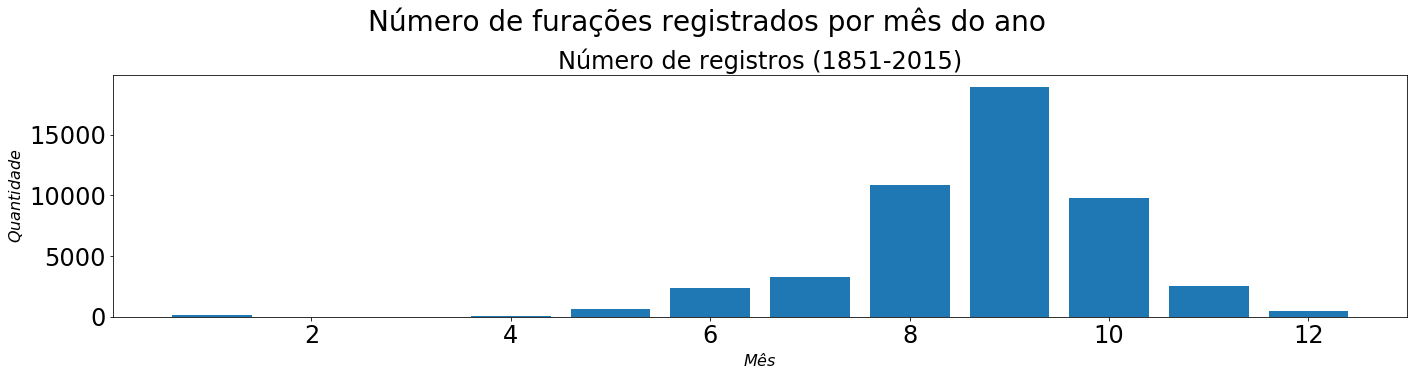

In [119]:
fig, ax = plt.subplots(1,1)#, figsize=(16,10))
fig.suptitle('Número de furações registrados por mês do ano', fontsize=28, y=1.06)

ax.bar(data_atl.groupby(['Month'])['Month'].mean(), data_atl.groupby(['Month'])['ID'].count(), ls = '--')
ax.tick_params(labelsize=24)
ax.set_title(f'Número de registros (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Mês$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)
# ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)

plt.savefig("../figs/furacoes_mes.jpg")

Período de furacões se concentra entre os meses de julho e novembro.
Isso deve estar relacionado com o período anterior (verão do hemisfério norte, onde acontece o maior número de casos)
O aquecimento das águas está intimamente ligado com a formação das massas de ar que ocasionam os furacões
Isso nos dá uma pista da forma de correlação temporal que devemos buscar para predizer os eventos

In [47]:
## Formataão dos dados para plot pressao x vento
data_atl_ext = data_atl.copy()
data_atl_mwmp = data_atl.copy()
data_atl_mw = data_atl.copy()

ind_nan_ext = []
ind_nan_mwmp = []
ind_nan_mw = []
for l in range(len(data_atl)):
    if (data_atl_mw['Maximum Wind'][l] < 0):
        ind_nan_mw.append(l)
        ind_nan_mwmp.append(l)
        ind_nan_ext.append(l)
    elif (data_atl_mwmp['Minimum Pressure'][l] < 0):
        ind_nan_mwmp.append(l)
        ind_nan_ext.append(l)
    elif (min(data_atl_ext['Low Wind NE'][l], data_atl_ext['Low Wind SE'][l],
              data_atl_ext['Low Wind SW'][l], data_atl_ext['Low Wind NW'][l], 
              data_atl_ext['Moderate Wind NE'][l], data_atl_ext['Moderate Wind SE'][l],
              data_atl_ext['Moderate Wind SW'][l], data_atl_ext['Moderate Wind NW'][l], 
              data_atl_ext['High Wind NE'][l], data_atl_ext['High Wind SE'][l],
              data_atl_ext['High Wind SW'][l], data_atl_ext['High Wind NW'][l]) < 0):
        ind_nan_ext.append(l)
data_atl_ext = data_atl_ext.drop(ind_nan_ext, 0)
data_atl_mwmp = data_atl_mwmp.drop(ind_nan_mwmp, 0)
data_atl_mw = data_atl_mw.drop(ind_nan_mw, 0)

print(len(data_atl_ext))
print(len(data_atl_mwmp))
print(len(data_atl_mw))

5921
18436
48767


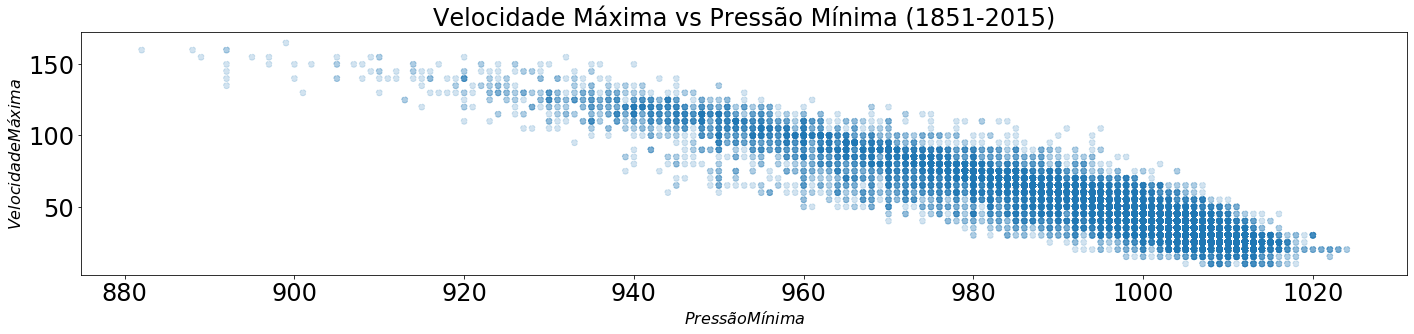

In [49]:
fig, ax = plt.subplots(1,1)#, figsize=(16,10))
#fig.suptitle('Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=28, y=1.06)

ax.scatter(data_atl_mwmp['Minimum Pressure'], data_atl_mwmp['Maximum Wind'], alpha = 0.2, ls = '--') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Velocidade Máxima vs Pressão Mínima (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Pressão Mínima$', fontsize=16)
ax.set_ylabel(r'$Velocidade Máxima$', fontsize=16)
# ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)
plt.savefig('../figs/pressaoMin_Velo_max.jpg')

Abaixo formatamos as Latitudes e Longitudes para remover os terminadores W, E, N e S. Como indicador de hemisfério, usamos sinal negativo para sul e oeste e positovo para norte e leste. Precisaremos que esses dados sejam numericos para aplicações futuras e não textuais.

In [130]:
data_atl[['Latitude','Longitude']].dtypes

Latitude     object
Longitude    object
dtype: object

In [131]:
data_atl.Latitude = data_atl.Latitude.apply(lambda x: -float(x.rstrip("S")) if x.endswith("S") else float(x.rstrip("N")))
data_atl.Longitude = data_atl.Longitude.apply(lambda x: -float(x.rstrip("W")) if x.endswith("W") else float(x.rstrip("E")))
data_atl[['Latitude','Longitude']].describe()

,Latitude,Longitude
count,49105.000000,49105.000000
mean,27.044904,-65.682533
std,10.077880,19.687240
min,7.200000,-359.100000
25%,19.100000,-81.000000
50%,26.400000,-68.000000
75%,33.100000,-52.500000
max,81.000000,63.000000


R^2_train = 0.40918060978409
Parâmetro_const  = -3940.349139351199
Parâmetro_Year  = 2.192423797184304


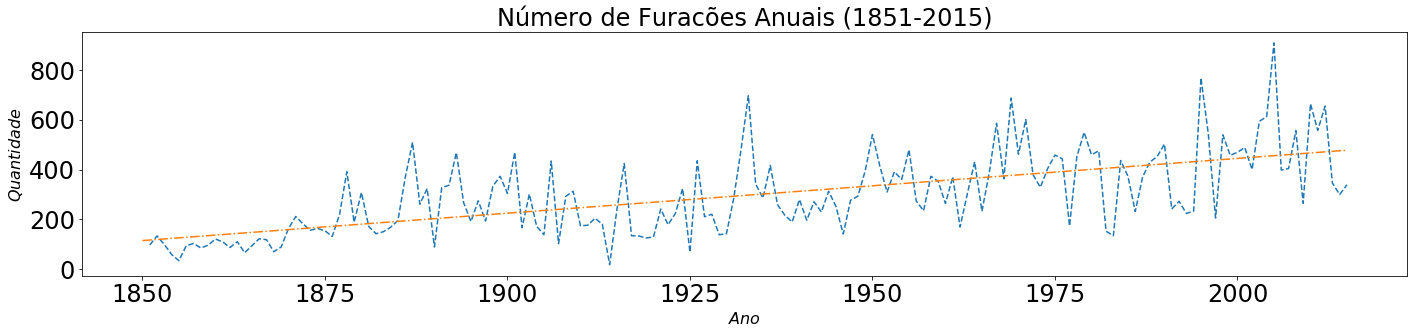

In [135]:

X_train = data_atl.groupby(['Year'])['Year'].mean()
y_train = data_atl.groupby(['Year'])['ID'].count()
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared

print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))


ax.plot(data_atl.groupby(['Year'])['ID'].count(), ls = '--') 
ax.plot([1850, 2015], [w0, w1], ls = '-.') 
ax.tick_params(labelsize=24)
ax.set_title(f'Número de Furacões Anuais (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)
# ax.legend(loc='best', fontsize=12);

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)
plt.savefig('../figs/numero_furacoes1851-2015.jpg')


Vemos acima que o número de registro de furações tem crescido desde 1850, mas isso se deve à maior capacidade de detecção com o passar dos anos.

R^2_train = 0.49772308255924613
Parâmetro_const  = 345.3529584491673
Parâmetro_Year  = -0.15025433346159078


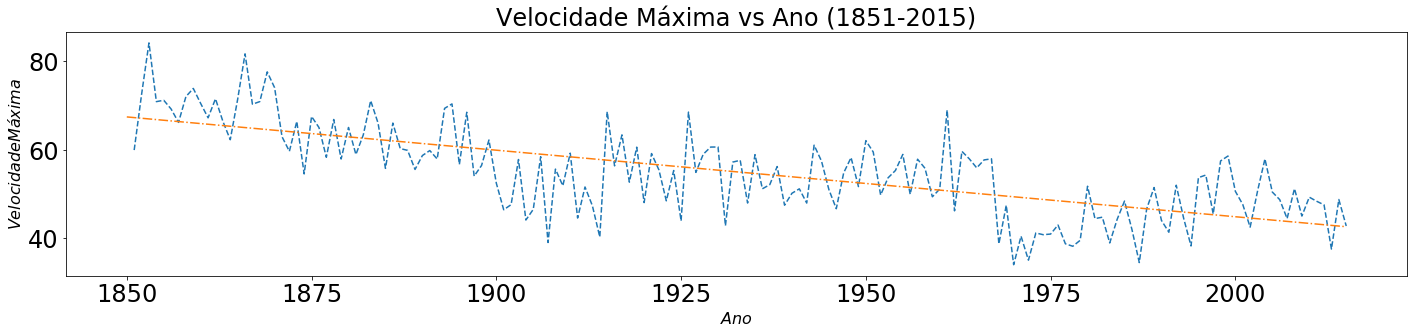

In [138]:

X_train = data_atl_mw.groupby(['Year'])['Year'].mean()
y_train = data_atl_mw.groupby(['Year'])['Maximum Wind'].mean()
X_train2 = sm.add_constant(X_train)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared

print(f'R^2_train = {r2_train}')

print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))


ax.plot(data_atl_mw.groupby(['Year'])['Year'].mean(), data_atl_mw.groupby(['Year'])['Maximum Wind'].mean(), ls = '--')
ax.plot([1850, 2015], [w0, w1], ls = '-.') 
ax.tick_params(labelsize=24)
ax.set_title(f'Velocidade Máxima vs Ano (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Velocidade Máxima$', fontsize=16)


fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)
plt.savefig('../figs/maxwind_1851-2015.jpg')


Vemos também que a velocidade máxima de vento sustentada pelos furacões reduziu, mas isso também se deve à maior capacidade de registro de eventos de pequeno porte, que acabam pesando a média para baixo. Assim, para não enviesar nossos dados, filtraremos os registros de pequeno porte; Consideramos apenas tempestades cuja duração em dias é maior que 2, e cuja classificação na escala [Saffir-Simpson](https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale) seja no mínimo Tempestade Tropical.

Para essa classificação, a velocidade máxima sustentada de vento deve ultrapassar 63km/h o que equivale a 34 knots (milhas náuticas).


In [141]:
#Filtro de Duração
data_atl_fdur = data_atl_mw.copy()
duration = data_atl_mw.groupby(['ID'])['Date'].max()-data_atl_mw.groupby(['ID'])['Date'].min()
duration.name = 'Duration'
#print(duration)
data_atl_fdur = pd.merge(data_atl_fdur, duration, how='inner', left_on='ID', right_index=True)
data_atl_fdur['Duration'] = pd.to_numeric(data_atl_fdur['Duration'].dt.days, downcast='integer')
data_atl_fdur = data_atl_fdur[data_atl_fdur['Duration'] > 2]
print(len(data_atl_fdur))

46350


In [142]:
#Filtro de Max_Windspeed
data_atl_fwind = data_atl_fdur.copy()
data_atl_fwind = data_atl_fwind[data_atl_fwind['Maximum Wind'] > 34]
print(len(data_atl_fwind))

35696


Vejamos os novos plots com os dados filtrados:

R^2_train = 0.15573477903937427
Parâmetro_const  = -1661.4327723310091
Parâmetro_Year  = 0.9714289530628057


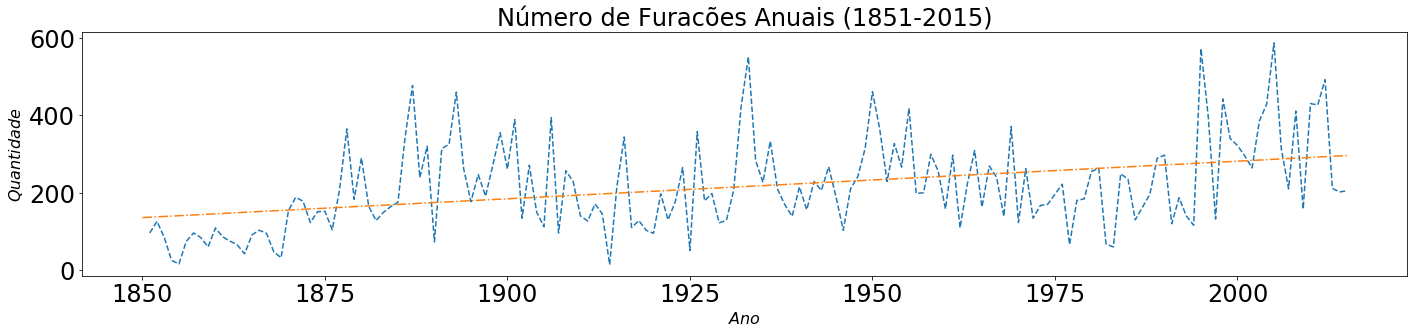

In [145]:
# Com o novo filtro, o viés do aumento no número de furacões ao longo dos anos reduziu, mas ainda há um aumento
# Isso mostra que essa tendência pode ser algo não viesada, e que gera preocupação pelo futuro
X_train = data_atl_fwind.groupby(['Year'])['Year'].mean()
y_train = data_atl_fwind.groupby(['Year'])['ID'].count()
X_train2 = sm.add_constant(X_train) 
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared

print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)

ax.plot(data_atl_fwind.groupby(['Year'])['ID'].count(), ls = '--') 
ax.plot([1850, 2015], [w0, w1], ls = '-.') 
ax.tick_params(labelsize=24)
ax.set_title(f'Número de Furacões Anuais (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Quantidade$', fontsize=16)


fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)
plt.savefig('../figs/filtered_numero_furacoes1851-2015.jpg')

R^2_train = 0.11158706746149893
Parâmetro_const  = 167.44362825887208
Parâmetro_Year  = -0.05470982174808241


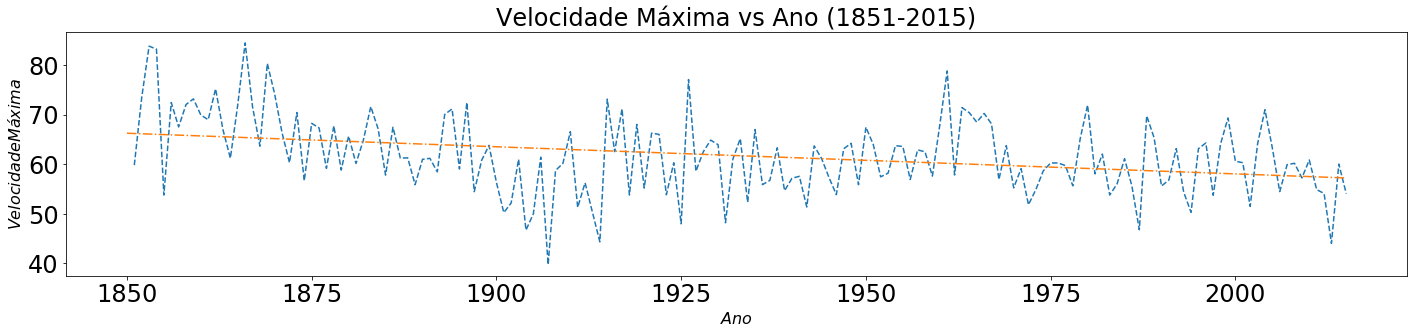

In [146]:
X_train = data_atl_fwind.groupby(['Year'])['Year'].mean()
y_train = data_atl_fwind.groupby(['Year'])['Maximum Wind'].mean()
X_train2 = sm.add_constant(X_train) #np.array(X_train).reshape(X_train.shape[0],1)
OLS_obj = OLS(y_train, X_train2)
OLSModel = OLS_obj.fit()

r2_train = OLSModel.rsquared

print(f'R^2_train = {r2_train}')
#print(f'R^2_test  = {r2_test}')
print(f'Parâmetro_const  = {OLSModel.params[0]}')
print(f'Parâmetro_Year  = {OLSModel.params[1]}')

w0 = OLSModel.params[0] + 1850*OLSModel.params[1]
w1 = OLSModel.params[0] + 2015*OLSModel.params[1]

fig, ax = plt.subplots(1,1)#, figsize=(16,10))


ax.plot(data_atl_fwind.groupby(['Year'])['Year'].mean(), data_atl_fwind.groupby(['Year'])['Maximum Wind'].mean(), ls = '--') 
ax.plot([1850, 2015], [w0, w1], ls = '-.') #, label=r'$Furacões$ $=$ $0$')
ax.tick_params(labelsize=24)
ax.set_title(f'Velocidade Máxima vs Ano (1851-2015)', fontsize=24)
ax.set_xlabel(r'$Ano$', fontsize=16)
ax.set_ylabel(r'$Velocidade Máxima$', fontsize=16)

fig.set_figheight(5)
fig.set_figwidth(20)
fig.tight_layout(pad=2.0)
plt.savefig('../figs/filtered_maxwind_1851-2015.jpg')

Com o novo filtro, o viés da redução da velocidade máxima sustentada de vento reduziu, quase para o nível constante
Isso pode significar que os filtros estão relativamente bem adequados para retirada do viés inicial dos dados.

Geraremos então um novo DataFrame com algums filtros importantes:

- Velocidade Máxima Sustentada > 34 milhas náuticas
- Duração > 2 dias
- Furacões a partir de 1950 (quando a capacidade de medição começa a evoluir

O código abaixo aplica esses filtros.


In [172]:
data_atl_mw2 = data_atl.copy()

data_atl_mw2_filtrado3 = data_atl_mw2.copy()
Lat_min = data_atl_mw2_filtrado3.groupby(['ID'])['Latitude'].first()
Lat_min.name = 'Lat_min'

data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, Lat_min, how='inner', left_on='ID', right_index=True)

data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[abs(data_atl_mw2_filtrado3['Lat_min'] - 12.5) > 0]


Lon_min = data_atl_mw2_filtrado3.groupby(['ID'])['Longitude'].min()
Lon_min.name = 'Lon_min'

data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, Lon_min, how='inner', left_on='ID', right_index=True)
#print(data_atl_mw2_filtrado3)
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Lon_min'] > -180]

Wind_max = data_atl_mw2_filtrado3.groupby(['ID'])['Maximum Wind'].max()
Wind_max.name = 'Wind_max'
#print(Wind_max)
data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, Wind_max, how='inner', on='ID')#left_on='ID', right_index=True)
#print(data_atl_mw2_filtrado3)
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Wind_max'] > 34]

data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Year'] > 1950]

duration = data_atl_mw2_filtrado3.groupby(['ID'])['Date'].max()-data_atl_mw2_filtrado3.groupby(['ID'])['Date'].min()
duration.name = 'Duration'
#print(duration)
data_atl_mw2_filtrado3 = pd.merge(data_atl_mw2_filtrado3, duration, how='inner', left_on='ID', right_index=True)
data_atl_mw2_filtrado3['Duration'] = pd.to_numeric(data_atl_mw2_filtrado3['Duration'].dt.days, downcast='integer')
data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3[data_atl_mw2_filtrado3['Duration'] > 2]

data_atl_mw2_filtrado3 = data_atl_mw2_filtrado3.drop(['Lat_min', 'Lon_min', 'Wind_max'], 1)
#data_atl_mw2_filtrado3.head()

print(len(data_atl_mw2_filtrado3))
print(len(data_atl.groupby(['ID'])['ID'].count()))
print(len(data_atl_mw2_filtrado3.groupby(['ID'])['ID'].count()))

print(len(data_atl))
print(len(data_atl_mw2))
data_atl_mw2_filtrado3.head()

22386
1814
685
49105
49105


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day,Duration
21948,AL011951,UNNAMED,1951-01-02,1200,,EX,30.5,-58.0,50,-999,...,-999,-999,-999,-999,-999,-999,1951,1,2,10
21949,AL011951,UNNAMED,1951-01-02,1800,,EX,29.9,-56.8,45,-999,...,-999,-999,-999,-999,-999,-999,1951,1,2,10
21950,AL011951,UNNAMED,1951-01-03,0,,EX,29.0,-55.7,45,-999,...,-999,-999,-999,-999,-999,-999,1951,1,3,10
21951,AL011951,UNNAMED,1951-01-03,600,,EX,27.5,-54.8,45,-999,...,-999,-999,-999,-999,-999,-999,1951,1,3,10
21952,AL011951,UNNAMED,1951-01-03,1200,,EX,26.5,-54.5,45,-999,...,-999,-999,-999,-999,-999,-999,1951,1,3,10


Uma limpeza final será feita nas entradas de texto:

In [180]:
df = data_atl_mw2_filtrado3.copy()
np.unique(df.Name)[0:5],np.unique(df.Event),np.unique(df.Status)

(array(['                AMY', '                ANA',
        '                BOB', '                DOG',
        '                DON'], dtype=object),
 array(['  ', ' C', ' G', ' I', ' L', ' P', ' R', ' S', ' T', ' W'],
       dtype=object),
 array([' DB', ' EX', ' HU', ' LO', ' SD', ' SS', ' TD', ' TS', ' WV'],
       dtype=object))

Veja que as entradas estão espaçadas, abaixo corrigimos isso:

In [181]:
df['Name'] = df['Name'].apply(lambda x: x.strip())
df['Event'] = df['Event'].apply(lambda x: x.strip())
df['Status'] = df['Status'].apply(lambda x: x.strip())

np.unique(df.Name)[0:5],np.unique(df.Event),np.unique(df.Status)

(array(['ABBY', 'ABLE', 'AGNES', 'ALBERTO', 'ALEX'], dtype=object),
 array(['', 'C', 'G', 'I', 'L', 'P', 'R', 'S', 'T', 'W'], dtype=object),
 array(['DB', 'EX', 'HU', 'LO', 'SD', 'SS', 'TD', 'TS', 'WV'], dtype=object))

In [184]:
#Salvando em csv
data_atl_mw2_filtrado3 = df.copy()
data_atl_mw2_filtrado3.to_csv('data_atl_mw2_filtrado3.csv', encoding='utf-8', index=False)

## União dos dados via k-NN ponderado

Abaixo vamos gerar um novo dataframe que pegará o filtrado3.csv gerado acima e buscará os dados climáticos nos datasets da ICOADS diretamente dos arquivos .nc. Faremos essa busca via coordenadas e para lidar com dados faltantes implementaremos um k-NN ponderado pelo inverso das distâncias entre as coordenadas originais e o vizinho considerado no algoritmo.

### Leitura dos dados e limpezas adicionais

In [185]:
df = pd.read_csv('data_atl_mw2_filtrado3.csv',parse_dates=['Date'])

df.dtypes

ID                          object
Name                        object
Date                datetime64[ns]
Time                         int64
Event                       object
Status                      object
Latitude                   float64
Longitude                  float64
Maximum Wind                 int64
Minimum Pressure             int64
Low Wind NE                  int64
Low Wind SE                  int64
Low Wind SW                  int64
Low Wind NW                  int64
Moderate Wind NE             int64
Moderate Wind SE             int64
Moderate Wind SW             int64
Moderate Wind NW             int64
High Wind NE                 int64
High Wind SE                 int64
High Wind SW                 int64
High Wind NW                 int64
Year                         int64
Month                        int64
Day                          int64
Duration                     int64
dtype: object

In [188]:
pd.DataFrame(zip(df.columns,
                 [np.sum(df[x] == -999)/len(df) for x in df.columns])
             ,columns = ['Variable','Missing Ratio'])

,Variable,Missing Ratio
0,ID,0.000000
1,Name,0.000000
2,Date,0.000000
3,Time,0.000000
4,Event,0.000000
5,Status,0.000000
6,Latitude,0.000000
7,Longitude,0.000000
8,Maximum Wind,0.000000
9,Minimum Pressure,0.256723


Removeremos as colunas abaixo, pois não utilizaremos nas análises e são muitos esparsas

In [189]:
df = df.drop(['Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],axis = 1)

Na célula abaixo, lemos os dados climáticos e os salvamos en variáveis para uso futuro.

In [13]:
sst_mean = nc.Dataset('sst.mean.nc','r')
rhum_mean = nc.Dataset('rhum.mean.nc','r')
wspd_mean = nc.Dataset('wspd.mean.nc','r')
slp_mean = nc.Dataset('slp.mean.nc','r')
# vwnd_mean = nc.Dataset('Datasets/vwnd.mean.nc','r')
# Resolvemos não considerar o vwnd por ser ruído
cldc_mean = nc.Dataset("cldc.mean.nc",'r')

lats = sst_mean.variables['lat'][:]
lons = sst_mean.variables['lon'][:]
time = sst_mean.variables['time'][:]

lons = [x-180 for x in lons]
lats = [x for x in lats]

sst = sst_mean.variables['sst'][:,:,:]
rhum = rhum_mean.variables['rhum'][:,:,:]
wspd = wspd_mean.variables['wspd'][:,:,:]
slp = slp_mean.variables['slp'][:,:,:]
cldc = cldc_mean.variables['cldc'][:,:,:]

sst_mean.close()
wspd_mean.close()
rhum_mean.close()
slp_mean.close()
cldc_mean.close()

### Formula da distância

Dados duas coordenadas $(\varphi_1,\lambda_1)$ e ($\varphi_2,\lambda_2)$ em radianos, a [Fórmula Haversine](https://wikimedia.org/api/rest_v1/media/math/render/svg/a65dbbde43ff45bacd2505fcf32b44fc7dcd8cc0) é capaz de calcular a distância real entre esses dois pontos no mapa:

![teste](https://wikimedia.org/api/rest_v1/media/math/render/svg/a65dbbde43ff45bacd2505fcf32b44fc7dcd8cc0)

Onde $r$ é o raio da Terra.

Usando $r$ aproximadamente igual a $6371$ km o valor de $d$ será a distância em km dos dois pontos dados em coordenadas geográficas.

Abaixo, seguimos uma implementação equivalente obtida no [Stack Overflow](https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude).

In [14]:

def distance(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6371.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    if R*c==0:
        return 0.000000001 #Handling Zero Division problems
    else:
        return R * c

### k-NN ponderado por inverso da distância

Abaixo segue a implementação de algumas funções auxiliares para realizar esse preenchimento de dados almejado. o que queremos é dos dados que filtramos do HURDAT, para cada linha, usando as coordenadas geográficas, gerar novas colunas contendo os dados do ICOADS para aquela data espefícica e aquela coordenada específica.

Por conta de dados faltantes no ICOADS, nem sempre existirá registros para todas as coordenadas. Assim, buscamos os $k$ vizinhos mais próximos a calculamos a média entre eles, porém a média é ponderada pelo inverso da distância entre o vizinho e a coordenada original (usando a Fórmula Haversive). Sendo assim, pontos mais distantes terão menor peso na média, enquanto pontos mais próximos serão considerados mais importantes.

Por simplicidade, usamos $k=15$.

Funcionamento das funções:

 - get_coords: recebe uma coordenada e a lista de coordenadas disponíveis no ICOADS. Retorna uma coordenada que existe na lista passada. Precisamos dessa função pois os dados de coordenadas do ICOADS são intervalados 2 a 2.
 - get_neighboors: recebe uma data, latitude, longitude, uma array de dados do ICOADS e a quantidade de vizinhos a buscar. Retorna uma lista de $k$ vizinhos e uma lista de distâncias em kilometros.
 - get_data: usa as funções acima para gerar a média ponderada pelo inverso da distância
 - get_data_df: aplica as funções acima para gerar uma nova coluna nos dados HURDAT2 da forma como almejado inicialmente.

In [15]:
def get_coord(coord,l):
    if int(coord) in l:
        return int(coord)
    elif int(coord)+1 in l:
        return int(coord)+1
    elif int(coord)-1 in l:
        return int(coord)-1
    elif int(coord)+2 in l:
        return int(coord)+2
    elif int(coord)-2 in l:
        return int(coord)-2
    
def get_neighboors(t,lat,lon,marray,k):
    nb = []
    dist = []

    lat_data = get_coord(lat,lats) #nearest lat in our lats list
    lon_data = get_coord(lon,lons)
    lat_i = lats.index(lat_data)
    lon_i = lons.index(lon_data)
    if marray[t,lat_i,lon_i]:
        nb.append(marray[t,lat_i,lon_i])
        dist.append(distance(lat,lon,lat_data,lon_data))
    j=1
    while len(nb)<k:
        
        lower_i = (lat_i-j)#%90
        upper_i = (lat_i+j)#%90
        right_i = (lon_i+j)#%180
        left_i = (lon_i-j)#%180
#         if right_i>=len()
        left_values = marray[t,lower_i:upper_i,left_i]
        upper_values = marray[t,upper_i,left_i:right_i]
        right_values = marray[t,upper_i:lower_i:-1,right_i]
        lower_values = marray[t,lower_i,right_i:left_i:-1]
        
        [nb.append(x) for x in left_values if x]
        [dist.append(distance(lat,lon,lats[i],lons[left_i])) for i in range(len(left_values)) if left_values[i]]
        if len(nb)>=k:
            break
        [nb.append(x) for x in upper_values if x]
        [dist.append(distance(lat,lon,lats[upper_i],lons[i])) for i in range(len(upper_values)) if upper_values[i]]
        if len(nb)>=k:
            break
        [nb.append(x) for x in right_values if x]
        [dist.append(distance(lat,lon,lats[i],lons[right_i])) for i in range(len(right_values)) if right_values[i]]
        if len(nb)>=k:
            break
        [nb.append(x) for x in lower_values if x]
        [dist.append(distance(lat,lon,lats[lower_i],lons[i])) for i in range(len(lower_values)) if lower_values[i]]
        if len(nb)>=k:
            break
        j+=1
    if prob!=[]:
        print(prob)
    return nb,dist
        
        

In [16]:
period = pd.date_range(start = "1800-01-01",end = "2020-07-01", freq = "MS").to_pydatetime().tolist()
def get_data(datetime,lat,lon,dataset,k):#k is the number of neighboors
    year = datetime.year
    month = datetime.month
    time_index = period.index(dt.datetime(year, month, 1, 0, 0))
    nb,dist = get_neighboors(time_index,lat,lon,dataset,k)
    inv_dist = [1/x for x in dist]
    return sum(nb[i]*inv_dist[i] for i in range(len(nb)))/sum(inv_dist)

In [17]:
def get_data_df(df,dataset,label,k=15):
    output = pd.DataFrame(np.zeros([len(df),1]),columns = [label])
    for i in range(len(df)):
        output.loc[i,label] = get_data(df.Date[i],df.Latitude[i],df.Longitude[i],dataset,k)
    return output

Abaixo executamos tudo que foi implementado acima para gerar o novo dataframe. Salvamos em um novo csv que usaremos nas próximas análises.

In [18]:
%%time
# Esta célula demora um pouco a ser executada; Todos essas dados já estão salvos em data_atl_merged2.csv
df.loc[:,'sst']=get_data_df(df,sst,'sst')
print("OK -- sst")
df.loc[:,'rhum']=get_data_df(df,rhum,'rhum')
print("OK -- rhum")
df.loc[:,'wspd']=get_data_df(df,rhum,'wspd')
print("OK -- wspd")
df.loc[:,'slp']=get_data_df(df,slp,'slp')
print("OK -- slp")
df.loc[:,'cldc']=get_data_df(df,cldc,'cldc')
print("OK -- cldc\n")
df.columns

OK -- sst
OK -- rhum
OK -- wspd
OK -- slp
OK -- cldc

CPU times: user 2min 34s, sys: 868 ms, total: 2min 35s
Wall time: 2min 33s


Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Year',
       'Month', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'sst', 'rhum',
       'wspd', 'slp', 'cldc'],
      dtype='object')

In [23]:
df.to_csv('data_atl_merged2.csv',index=0)
df = pd.read_csv('data_atl_merged2.csv',parse_dates=['Date'])
df.dtypes

ID                          object
Name                        object
Date                datetime64[ns]
Time                         int64
Event                       object
Status                      object
Latitude                   float64
Longitude                  float64
Maximum Wind                 int64
Minimum Pressure             int64
Date_c                      object
Year                         int64
Month                        int64
Day                          int64
Latitude_c                 float64
Longitude_c                float64
Duration                     int64
sst                        float64
rhum                       float64
wspd                       float64
slp                        float64
cldc                       float64
dtype: object